In [1]:
import numpy as np
import torch
import csv
import pandas as pd
import io
from numpy import random
import torch.nn.functional as F
BATCH_SIZE = 32
import matplotlib.pyplot as plt
import pickle

In [2]:

if torch.cuda.is_available and torch.has_cudnn:
    device = torch.device('cuda')
else:
    device = torch.device("cpu")

#device = torch.device("cpu")

In [3]:
#load data
def load_tsv(filename):
    train_s1 = []
    train_s2 = []
    train = []
    train_label = []
    with open(filename) as tsvfile:
      reader = csv.reader(tsvfile, delimiter='\t')
      for row in reader:
            
        train_s1.append(row[0].split())
        
        train_s2.append(row[1].split())
        
        if row[2] == 'neutral': 
            train_label.append(1)
        elif row[2] == 'entailment':
            train_label.append(2)
        else:
            train_label.append(0)
    train_s1 = train_s1[1:]
    train_s2 = train_s2[1:]
    
    
    train_label = train_label[1:]
    
    return train_s1,train_s2, train_label

In [4]:
train_s1,train_s2,train_label = load_tsv('snli_train.tsv')
val_s1,val_s2,val_label = load_tsv('snli_val.tsv')


In [5]:
ft_home = './'
words_to_load = 50000

import numpy as np

with open(ft_home + 'wiki-news-300d-1M.vec') as f:
    loaded_embeddings_ft = np.zeros((words_to_load + 2, 300))
    words_ft = {}
    idx2words_ft = {}
    ordered_words_ft = []
    
    for i, line in enumerate(f):
        if i >= words_to_load: 
            break
        s = line.split()
        loaded_embeddings_ft[i, :] = np.asarray(s[1:])
        words_ft[s[0]] = i
        idx2words_ft[i] = s[0]
        ordered_words_ft.append(s[0])
        
#words_ft: {word: idx}, token2id
#idx2words_ft: {idx: word}, id2token
#ordered_words_ft[idx] = word
#loaded_embeddings_ft[idx] = embedding vector

idx_pad = len(words_ft)
idx_unk = len(words_ft) + 1
words_ft['<pad>'] = idx_pad
words_ft['<unk>'] = idx_unk
idx2words_ft[idx_pad] = '<pad>'
idx2words_ft[idx_unk] = '<unk>'
ordered_words_ft.append('<pad>')
ordered_words_ft.append('<unk>')
loaded_embeddings_ft[idx_pad] = np.zeros((300,))
loaded_embeddings_ft[idx_unk] = random.normal(loc=0.0, scale=1.0, size=300)



In [6]:
# convert token to id in the dataset
def token2index_dataset(tokens_data):
    indices_data = []
    for tokens in tokens_data:
        index_list = []
        for token in tokens:
            try:
                index_list.append(words_ft[token])
            except KeyError:
                index_list.append(idx_unk)
        #index_list = [words_ft[token] if token in words_ft.keys() else idx_unk for token in tokens]
        indices_data.append(index_list)
    return indices_data

train_s1_indices = token2index_dataset(train_s1)
train_s2_indices = token2index_dataset(train_s2)
val_s1_indices = token2index_dataset(val_s1)
val_s2_indices = token2index_dataset(val_s2)


# double checking
assert len(train_s1_indices) == len(train_s1)
assert len(train_s2_indices) == len(train_s2)
assert len(val_s1_indices) == len(val_s1)
assert len(val_s2_indices) == len(val_s2)



In [7]:
#Create Data Loader

import torch
from torch.utils.data import Dataset

class load_dataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list_s1,data_list_s2, target_list):
        """
        @param data_list_s1: list of s1 tokens 
        @param data_list_s2: list of s2 tokens
        @param target_list: list of s1 targets 

        """
        self.data_list_s1 = data_list_s1
        self.data_list_s2 = data_list_s2
        self.target_list = target_list
        assert (len(self.data_list_s1) == len(self.target_list))
        assert (len(self.data_list_s2) == len(self.target_list))

    def __len__(self):
        return len(self.data_list_s1)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        
        token_idx_s1 = self.data_list_s1[key]
        token_idx_s2 = self.data_list_s2[key]
        label = self.target_list[key]
        return [token_idx_s1, token_idx_s2, len(token_idx_s1), len(token_idx_s2),label]

def collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    data_list_s1 = []
    data_list_s2 = []
    label_list = []
    length_list_s1 = []
    length_list_s2 = []
    #print("collate batch: ", batch[0][0])
    #batch[0][0] = batch[0][0][:MAX_SENTENCE_LENGTH]
    for datum in batch:
        label_list.append(datum[4])
        length_list_s1.append(datum[2])
        length_list_s2.append(datum[3])
    # padding
    #find max length in each batch
    
    length_list_s1_sorted = sorted(length_list_s1)
    s1_ceiling = length_list_s1_sorted[int(round(len(batch)*0.99))-1]
    length_list_s2_sorted = sorted(length_list_s2)
    s2_ceiling = length_list_s2_sorted[int(round(len(batch)*0.99))-1]
    
    max_s1 = 0
    max_s2 = 0
    for datum in batch:
        if datum[2] > max_s1:
            max_s1 = datum[2]
        
        if datum[3] > max_s2:
            max_s2 = datum[3]
    '''
    if max_s1>s1_ceiling:
        max_s1 = s1_ceiling
    if max_s2>s2_ceiling:
        max_s2 = s2_ceiling
    
    final_length_s1 = []
    final_length_s2 = []
    final_label = []
    '''
    for datum in batch:
        '''
        if datum[2]>s1_ceiling:
            datum[0] = datum[0][:s1_ceiling]
            datum[2] = s1_ceiling
        if datum[3]>s2_ceiling:
            datum[1] = datum[1][:s2_ceiling]
            datum[3] = s2_ceiling
        '''
        

        padded_vec_s1 = np.pad(np.array(datum[0]), 
                                pad_width=((0,max_s1 - datum[2])), 
                                mode="constant", constant_values=0)
        padded_vec_s2 = np.pad(np.array(datum[1]), 
                                pad_width=((0,max_s2 - datum[3])), 
                                mode="constant", constant_values=0)
        data_list_s1.append(padded_vec_s1)
        data_list_s2.append(padded_vec_s2)
        '''
        final_length_s1.append(datum[2])
        final_length_s2.append(datum[3])
        final_label.append(datum[4])
        '''
    #return [torch.from_numpy(np.array(data_list_s1)), torch.from_numpy(np.array(data_list_s2)),torch.LongTensor(final_length_s1), torch.LongTensor(final_length_s2),torch.LongTensor(final_label)]
    return [torch.from_numpy(np.array(data_list_s1)), torch.from_numpy(np.array(data_list_s2)),torch.LongTensor(length_list_s1), torch.LongTensor(length_list_s2),torch.LongTensor(label_list)]

In [8]:
# create pytorch dataloader
train_loader = load_dataset(train_s1_indices,train_s2_indices, train_label)
val_loader = load_dataset(val_s1_indices, val_s2_indices, val_label)

BATCH_SIZE = 32
train_dataset = load_dataset(train_s1_indices,train_s2_indices, train_label)
train_loader = torch.utils.data.DataLoader(dataset=(train_dataset), 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=collate_func,
                                           shuffle=True)

val_dataset = load_dataset(val_s1_indices,val_s2_indices, val_label)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=collate_func,
                                           shuffle=True)

In [9]:
t = torch.randn(2, 31, 100)
t.shape

torch.Size([2, 31, 100])

In [9]:
import torch.nn as nn
class RNN(nn.Module):
    def __init__(self, weight, emb_size, hidden_size, num_layers, num_classes,element_mul):
        # RNN Accepts the following hyperparams:
        # hidden_size: Hidden Size of layer in RNN
        # num_layers: number of layers in RNN
        # num_classes: number of output classes
        # vocab_size: vocabulary size
        super(RNN, self).__init__()

        self.num_layers, self.hidden_size = num_layers, hidden_size
        
        self.element_mul = element_mul
        
        #self.embedding = nn.Embedding(vocab_size, emb_size, padding_idx=PAD_IDX)
        self.embedding = nn.Embedding.from_pretrained(torch.Tensor(weight), freeze = True).float()
        #self.rnn = nn.RNN(emb_size, hidden_size, num_layers, batch_first=True)
        self.rnn = nn.GRU(emb_size, hidden_size,num_layers,batch_first = True, bidirectional = True)
        
        if element_mul == False:
            self.fc = nn.Sequential(
                nn.Linear(2*hidden_size, hidden_size), 
                nn.ReLU(inplace=True), 
                nn.Linear(hidden_size, num_classes))
        else:
            self.fc = nn.Sequential(
                nn.Linear(hidden_size, hidden_size), 
                nn.ReLU(inplace=True), 
                nn.Linear(hidden_size, num_classes))
        self.fc1 = nn.Linear(2*hidden_size, hidden_size)
        self.relu = nn.LeakyReLU(inplace=True)
        self.fc2 = nn.Linear(hidden_size, num_classes)
        

    def init_hidden(self, batch_size):
        # Function initializes the activation of recurrent neural net at timestep 0
        # Needs to be in format (num_layers, batch_size, hidden_size)
        hidden = torch.randn(2*self.num_layers, batch_size, self.hidden_size)

        return hidden
    
    
    
    def forward(self, s1, s2, lengths_s1,lengths_s2):
        # reset hidden state

        batch_size_s1, seq_len_s1 = s1.size()
        batch_size_s2, seq_len_s2 = s2.size()

        self.hidden_s1 = self.init_hidden(batch_size_s1).to(device)
        self.hidden_s2 = self.init_hidden(batch_size_s2).to(device)
        
        # pack padded sequence
        # Compute sorted sequence lengths
        _, idx_sort_s1 = torch.sort(lengths_s1, dim=0, descending=True)
        _, idx_unsort_s1 = torch.sort(idx_sort_s1, dim=0)
        _, idx_sort_s2 = torch.sort(lengths_s2, dim=0, descending=True)
        _, idx_unsort_s2 = torch.sort(idx_sort_s2, dim=0)
        
        lengths_s1 = list(lengths_s1[idx_sort_s1])
        lengths_s2 = list(lengths_s2[idx_sort_s2])

        # Sort x
        rnn_input_s1 = s1.index_select(0, idx_sort_s1)
        rnn_input_s2 = s2.index_select(0, idx_sort_s2)
        
        # get embedding of characters
        embed_s1 = self.embedding(rnn_input_s1)
        embed_s2 = self.embedding(rnn_input_s2)
        
        embed_s1 = torch.nn.utils.rnn.pack_padded_sequence(embed_s1, lengths_s1, batch_first=True)
        embed_s2 = torch.nn.utils.rnn.pack_padded_sequence(embed_s2, lengths_s2, batch_first=True)
        
        # fprop though RNN
        rnn_out_s1, self.hidden_s1 = self.rnn(embed_s1, self.hidden_s1)
        rnn_out_s2, self.hidden_s2 = self.rnn(embed_s2, self.hidden_s2)
        
        hn_s1 = torch.sum(self.hidden_s1, dim=0)
        hn_s2 = torch.sum(self.hidden_s2, dim=0)
        #hn_s1 = self.hidden_s1
        #hn_s2 = self.hidden_s2
        
        #unsort
        
        output_s1 = torch.index_select(hn_s1,0, idx_unsort_s1)
        output_s2 = torch.index_select(hn_s2,0, idx_unsort_s2)
        
        #concat
        if self.element_mul == True:
            rep = output_s1*output_s2
        else:
            rep = torch.cat((output_s1, output_s2), 1)
        #rep = torch.cat((output_s1, output_s2), 2)
        
        #FC layers
        res = self.fc(rep)
        
        
        return res
    
    
    

### CNN

In [10]:
class CNN(nn.Module):
    def __init__(self, weight,emb_size, hidden_size, kernel_size, num_classes):

        super(CNN, self).__init__()

        self.kernel_size, self.hidden_size = kernel_size, hidden_size
        self.embedding = nn.Embedding.from_pretrained(torch.Tensor(weight), freeze = True).float()
    
        self.conv1 = nn.Conv1d(emb_size, hidden_size, kernel_size=self.kernel_size, padding=1)
        self.conv2 = nn.Conv1d(hidden_size, hidden_size, kernel_size=self.kernel_size, padding=1)

        self.fc = nn.Sequential(
            nn.Linear(2*hidden_size, hidden_size), 
            nn.ReLU(inplace=True), 
            nn.Linear(hidden_size, num_classes))

    def forward(self, s1, s2, lengths_s1, lengths_s2):
        batch_size_s1, seq_len_s1 = s1.size()
        batch_size_s2, seq_len_s2 = s2.size()
        
        embed_s1 = self.embedding(s1).to(device)
        embed_s2 = self.embedding(s2).to(device)
       
        hidden_s1 = self.conv1(embed_s1.transpose(1,2)).transpose(1,2)
        hidden_s2 = self.conv1(embed_s2.transpose(1,2)).transpose(1,2)
        
        #hidden = F.relu(hidden.contiguous().view(-1, hidden.size(-1))).view(batch_size, seq_len, hidden.size(-1))
        #hidden = F.relu(hidden.contiguous().view(-1, hidden.size(-1))).view(batch_size, hidden.size(1), hidden.size(-1))
        
        hidden_s1 = F.relu(hidden_s1.contiguous().view(-1, hidden_s1.size(-1))).view(batch_size_s1, hidden_s1.size(1), hidden_s1.size(-1))
        hidden_s2 = F.relu(hidden_s2.contiguous().view(-1, hidden_s2.size(-1))).view(batch_size_s2, hidden_s2.size(1), hidden_s2.size(-1))
       
        hidden_s1 = self.conv2(hidden_s1.transpose(1,2)).transpose(1,2)
        hidden_s2 = self.conv2(hidden_s2.transpose(1,2)).transpose(1,2)
        
        hidden_s1 = F.relu(hidden_s1.contiguous().view(-1, hidden_s1.size(-1))).view(batch_size_s1, hidden_s1.size(1), hidden_s1.size(-1))
        hidden_s2 = F.relu(hidden_s2.contiguous().view(-1, hidden_s2.size(-1))).view(batch_size_s2, hidden_s2.size(1), hidden_s2.size(-1))
       
        hidden_s1,hidden_s1_idx = torch.max(hidden_s1, dim=1)
        
        hidden_s2,hidden_s2_idx = torch.max(hidden_s2, dim=1)
        
        rep = torch.cat([hidden_s1, hidden_s2], 1)
        output = self.fc(rep)
        
        
        return output

In [87]:

def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data_s1, data_s2, lengths_s1,lengths_s2, labels in loader:
        data_batch_s1, data_batch_s2, lengths_batch_s1,lengths_batch_s2, label_batch = data_s1.to(device), data_s2.to(device), lengths_s1.to(device),lengths_s2.to(device), labels.to(device)
        outputs = F.softmax(model(data_batch_s1, data_batch_s2, lengths_batch_s1,lengths_batch_s2), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]

        total += labels.size(0)
        correct += predicted.eq(label_batch.view_as(predicted)).sum().item()
    return (100 * correct / total)



In [39]:
from torch.autograd import Variable
torch.backends.cudnn.enabled=False


RNN: 

rnn0:default lr = 5e-4, hs = 200

rnn1: hs = 300

rnn2: hs = 400

rnn3: hs = 100

rnn4: hs = 400, element mul

rnn5: hs = 600, concat

### Run RNN

In [34]:

def train_rnn(hs,model_name,element_mul = False):
    best_acc = 0
    model = RNN(weight = loaded_embeddings_ft,
                emb_size= 300, 
                hidden_size=hs, 
                num_layers=1, 
                num_classes =3,
                element_mul = element_mul).to(device)

    learning_rate = 5e-4
    num_epochs = 10 # number epoch to train

    # Criterion and Optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


    # Train the model for s1
    total_step = len(train_loader)

    val_acc_list_rnn0 = []
    train_loss_rnn0 = []
    train_acc_list_rnn0 = []

    for epoch in range(num_epochs):
        for i, (data_s1, data_s2,lengths_s1, lengths_s2, labels) in enumerate(train_loader):
            data_s1 = data_s1.to(device)
            data_s2 = data_s2.to(device)
            lengths_s1 = lengths_s1.to(device)
            lengths_s2 = lengths_s2.to(device)
            labels = labels.to(device)
            model.train()
            optimizer.zero_grad()

            # Forward pass
            outputs = model(data_s1, data_s2, lengths_s1,lengths_s2)
            loss = criterion(outputs, labels)
            train_loss_rnn0.append(loss)

            # Backward and optimize
            loss.backward()
            optimizer.step()

            # validate every 100 iterations
            if i > 0 and i % 500 == 0:
                # validate
                val_acc = test_model(val_loader, model)
                train_acc_list_rnn0.append(test_model(train_loader, model))
                val_acc_list_rnn0.append(val_acc)
                if val_acc > best_acc:
                    best_acc = val_acc
                    torch.save(model.state_dict(), model_name+'.pth')
                print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format(
                           epoch+1, num_epochs, i+1, len(train_loader), val_acc))
    return train_acc_list_rnn0,val_acc_list_rnn0,train_loss_rnn0
        

In [40]:
train_acc_list_rnn1,val_acc_list_rnn1,train_loss_rnn1 = train_rnn(300,'rnn_hs_300')
with open('val_acc_list_rnn1', 'wb') as f:
     pickle.dump( val_acc_list_rnn1, f)
with open('train_acc_list_rnn1', 'wb') as f:
     pickle.dump(train_acc_list_rnn1, f)
with open('train_loss_rnn1', 'wb') as f:
     pickle.dump(train_loss_rnn1, f)

Epoch: [1/10], Step: [501/3125], Validation Acc: 56.6
Epoch: [1/10], Step: [1001/3125], Validation Acc: 58.7
Epoch: [1/10], Step: [1501/3125], Validation Acc: 59.6
Epoch: [1/10], Step: [2001/3125], Validation Acc: 59.6
Epoch: [1/10], Step: [2501/3125], Validation Acc: 60.2
Epoch: [1/10], Step: [3001/3125], Validation Acc: 61.4
Epoch: [2/10], Step: [501/3125], Validation Acc: 64.5
Epoch: [2/10], Step: [1001/3125], Validation Acc: 65.1
Epoch: [2/10], Step: [1501/3125], Validation Acc: 65.9
Epoch: [2/10], Step: [2001/3125], Validation Acc: 67.0
Epoch: [2/10], Step: [2501/3125], Validation Acc: 66.3
Epoch: [2/10], Step: [3001/3125], Validation Acc: 65.5
Epoch: [3/10], Step: [501/3125], Validation Acc: 66.7
Epoch: [3/10], Step: [1001/3125], Validation Acc: 66.9
Epoch: [3/10], Step: [1501/3125], Validation Acc: 68.1
Epoch: [3/10], Step: [2001/3125], Validation Acc: 67.2
Epoch: [3/10], Step: [2501/3125], Validation Acc: 66.1
Epoch: [3/10], Step: [3001/3125], Validation Acc: 66.9
Epoch: [4/10]

In [41]:
train_acc_list_rnn2,val_acc_list_rnn2,train_loss_rnn2 = train_rnn(400,'rnn_hs_400')
with open('val_acc_list_rnn2', 'wb') as f:
     pickle.dump( val_acc_list_rnn2, f)
with open('train_acc_list_rnn2', 'wb') as f:
     pickle.dump(train_acc_list_rnn2, f)
with open('train_loss_rnn2', 'wb') as f:
     pickle.dump(train_loss_rnn2, f)

Epoch: [1/10], Step: [501/3125], Validation Acc: 56.1
Epoch: [1/10], Step: [1001/3125], Validation Acc: 57.3
Epoch: [1/10], Step: [1501/3125], Validation Acc: 60.8
Epoch: [1/10], Step: [2001/3125], Validation Acc: 60.6
Epoch: [1/10], Step: [2501/3125], Validation Acc: 60.7
Epoch: [1/10], Step: [3001/3125], Validation Acc: 64.0
Epoch: [2/10], Step: [501/3125], Validation Acc: 63.4
Epoch: [2/10], Step: [1001/3125], Validation Acc: 65.8
Epoch: [2/10], Step: [1501/3125], Validation Acc: 65.5
Epoch: [2/10], Step: [2001/3125], Validation Acc: 65.3
Epoch: [2/10], Step: [2501/3125], Validation Acc: 64.9
Epoch: [2/10], Step: [3001/3125], Validation Acc: 66.1
Epoch: [3/10], Step: [501/3125], Validation Acc: 66.2
Epoch: [3/10], Step: [1001/3125], Validation Acc: 65.9
Epoch: [3/10], Step: [1501/3125], Validation Acc: 67.3
Epoch: [3/10], Step: [2001/3125], Validation Acc: 67.2
Epoch: [3/10], Step: [2501/3125], Validation Acc: 69.0
Epoch: [3/10], Step: [3001/3125], Validation Acc: 67.1
Epoch: [4/10]

In [42]:
train_acc_list_rnn3,val_acc_list_rnn3,train_loss_rnn3 = train_rnn(100,'rnn_hs_100')
with open('val_acc_list_rnn3', 'wb') as f:
     pickle.dump( val_acc_list_rnn3, f)
with open('train_acc_list_rnn3', 'wb') as f:
     pickle.dump(train_acc_list_rnn3, f)
with open('train_loss_rnn3', 'wb') as f:
     pickle.dump(train_loss_rnn3, f)

Epoch: [1/10], Step: [501/3125], Validation Acc: 56.8
Epoch: [1/10], Step: [1001/3125], Validation Acc: 58.1
Epoch: [1/10], Step: [1501/3125], Validation Acc: 61.1
Epoch: [1/10], Step: [2001/3125], Validation Acc: 59.2
Epoch: [1/10], Step: [2501/3125], Validation Acc: 60.4
Epoch: [1/10], Step: [3001/3125], Validation Acc: 60.2
Epoch: [2/10], Step: [501/3125], Validation Acc: 61.7
Epoch: [2/10], Step: [1001/3125], Validation Acc: 62.9
Epoch: [2/10], Step: [1501/3125], Validation Acc: 62.8
Epoch: [2/10], Step: [2001/3125], Validation Acc: 64.4
Epoch: [2/10], Step: [2501/3125], Validation Acc: 65.0
Epoch: [2/10], Step: [3001/3125], Validation Acc: 64.8
Epoch: [3/10], Step: [501/3125], Validation Acc: 66.8
Epoch: [3/10], Step: [1001/3125], Validation Acc: 66.5
Epoch: [3/10], Step: [1501/3125], Validation Acc: 64.3
Epoch: [3/10], Step: [2001/3125], Validation Acc: 66.5
Epoch: [3/10], Step: [2501/3125], Validation Acc: 67.7
Epoch: [3/10], Step: [3001/3125], Validation Acc: 65.7
Epoch: [4/10]

In [54]:
train_acc_list_rnn4,val_acc_list_rnn4,train_loss_rnn4 = train_rnn(400,'rnn_hs_400_emul',True)
with open('val_acc_list_rnn4', 'wb') as f:
     pickle.dump( val_acc_list_rnn4, f)
with open('train_acc_list_rnn4', 'wb') as f:
     pickle.dump(train_acc_list_rnn4, f)
with open('train_loss_rnn4', 'wb') as f:
     pickle.dump(train_loss_rnn4, f)

Epoch: [1/10], Step: [501/3125], Validation Acc: 49.2
Epoch: [1/10], Step: [1001/3125], Validation Acc: 53.7
Epoch: [1/10], Step: [1501/3125], Validation Acc: 55.7
Epoch: [1/10], Step: [2001/3125], Validation Acc: 56.6
Epoch: [1/10], Step: [2501/3125], Validation Acc: 60.6
Epoch: [1/10], Step: [3001/3125], Validation Acc: 61.0
Epoch: [2/10], Step: [501/3125], Validation Acc: 61.3
Epoch: [2/10], Step: [1001/3125], Validation Acc: 62.0
Epoch: [2/10], Step: [1501/3125], Validation Acc: 63.8
Epoch: [2/10], Step: [2001/3125], Validation Acc: 63.9
Epoch: [2/10], Step: [2501/3125], Validation Acc: 66.3
Epoch: [2/10], Step: [3001/3125], Validation Acc: 66.6
Epoch: [3/10], Step: [501/3125], Validation Acc: 66.7
Epoch: [3/10], Step: [1001/3125], Validation Acc: 68.5
Epoch: [3/10], Step: [1501/3125], Validation Acc: 65.8
Epoch: [3/10], Step: [2001/3125], Validation Acc: 67.4
Epoch: [3/10], Step: [2501/3125], Validation Acc: 68.1
Epoch: [3/10], Step: [3001/3125], Validation Acc: 68.3
Epoch: [4/10]

### Run CNN

0: default hs = 200, ks = 3

1: hs = 300, ks = 3

2: hs = 400, ks = 3

3: hs = 100, ks = 3

4: hs = 400, ks = 2

5: hs = 400, ks = 4

6: hs = 400, ks = 1


In [36]:
def train_cnn(hs,ks,model_name):    
    best_acc = 0

    model = CNN(weight = loaded_embeddings_ft,
                emb_size = 300, 
                hidden_size=hs, 
                kernel_size=ks, 
                num_classes =3).to(device)

    learning_rate = 5e-4
    num_epochs = 10 # number epoch to train

    # Criterion and Optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


    # Train the model for s1
    total_step = len(train_loader)

    val_acc_list_cnn0 = []
    train_loss_cnn0 = []
    train_acc_list_cnn0 = []

    for epoch in range(num_epochs):
        for i, (data_s1, data_s2,lengths_s1, lengths_s2, labels) in enumerate(train_loader):
            data_s1 = data_s1.to(device)
            data_s2 = data_s2.to(device)
            lengths_s1 = lengths_s1.to(device)
            lengths_s2 = lengths_s2.to(device)
            labels = labels.to(device)
            model.train()
            optimizer.zero_grad()

            # Forward pass
            outputs = model(data_s1, data_s2, lengths_s1,lengths_s2)
            loss = criterion(outputs, labels)
            train_loss_cnn0.append(loss)

            # Backward and optimize
            loss.backward()
            optimizer.step()

            # validate every 100 iterations
            if i > 0 and i % 500 == 0:
                # validate
                val_acc = test_model(val_loader, model)
                train_acc = test_model(train_loader, model)
                train_acc_list_cnn0.append(train_acc)
                val_acc_list_cnn0.append(val_acc)
                if val_acc > best_acc:
                    best_acc = val_acc
                    torch.save(model.state_dict(), model_name+'.pth''.pth')
                print('Epoch: [{}/{}], Step: [{}/{}], Train Loss: {}, Validation Acc: {}'.format(
                           epoch+1, num_epochs, i+1, len(train_loader), loss, val_acc))
    return train_acc_list_cnn0,val_acc_list_cnn0,train_loss_cnn0


In [14]:
train_acc_list_cnn1,val_acc_list_cnn1,train_loss_cnn1 = train_cnn(300,3,'cnn_hs_300_ks_3')
with open('val_acc_list_cnn1', 'wb') as f:
     pickle.dump( val_acc_list_cnn1, f)
with open('train_acc_list_cnn1', 'wb') as f:
     pickle.dump(train_acc_list_cnn1, f)
with open('train_loss_cnn1', 'wb') as f:
     pickle.dump(train_loss_cnn1, f)

Epoch: [1/10], Step: [501/3125], Train Loss: 0.9951513409614563, Validation Acc: 51.2
Epoch: [1/10], Step: [1001/3125], Train Loss: 0.9449820518493652, Validation Acc: 55.7
Epoch: [1/10], Step: [1501/3125], Train Loss: 0.9515377879142761, Validation Acc: 58.0
Epoch: [1/10], Step: [2001/3125], Train Loss: 0.983363151550293, Validation Acc: 59.0
Epoch: [1/10], Step: [2501/3125], Train Loss: 0.6476821899414062, Validation Acc: 63.0
Epoch: [1/10], Step: [3001/3125], Train Loss: 0.800731897354126, Validation Acc: 61.2
Epoch: [2/10], Step: [501/3125], Train Loss: 1.0268878936767578, Validation Acc: 61.2
Epoch: [2/10], Step: [1001/3125], Train Loss: 0.8809987902641296, Validation Acc: 60.2
Epoch: [2/10], Step: [1501/3125], Train Loss: 0.7096453905105591, Validation Acc: 61.7
Epoch: [2/10], Step: [2001/3125], Train Loss: 0.8559984564781189, Validation Acc: 60.7
Epoch: [2/10], Step: [2501/3125], Train Loss: 1.0098320245742798, Validation Acc: 62.1
Epoch: [2/10], Step: [3001/3125], Train Loss: 0

NameError: name 'pickle' is not defined

In [16]:
with open('val_acc_list_cnn1', 'wb') as f:
     pickle.dump( val_acc_list_cnn1, f)
with open('train_acc_list_cnn1', 'wb') as f:
     pickle.dump(train_acc_list_cnn1, f)
with open('train_loss_cnn1', 'wb') as f:
     pickle.dump(train_loss_cnn1, f)

In [17]:
train_acc_list_cnn2,val_acc_list_cnn2,train_loss_cnn2 = train_cnn(400,3,'cnn_hs_400_ks_3')
with open('val_acc_list_cnn2', 'wb') as f:
     pickle.dump( val_acc_list_cnn2, f)
with open('train_acc_list_cnn2', 'wb') as f:
     pickle.dump(train_acc_list_cnn2, f)
with open('train_loss_cnn2', 'wb') as f:
     pickle.dump(train_loss_cnn2, f)

Epoch: [1/10], Step: [501/3125], Train Loss: 0.9574393033981323, Validation Acc: 42.1
Epoch: [1/10], Step: [1001/3125], Train Loss: 0.9434483051300049, Validation Acc: 58.0
Epoch: [1/10], Step: [1501/3125], Train Loss: 0.8900450468063354, Validation Acc: 58.2
Epoch: [1/10], Step: [2001/3125], Train Loss: 0.8556941747665405, Validation Acc: 59.2
Epoch: [1/10], Step: [2501/3125], Train Loss: 0.7658823728561401, Validation Acc: 60.7
Epoch: [1/10], Step: [3001/3125], Train Loss: 0.7631287574768066, Validation Acc: 60.9
Epoch: [2/10], Step: [501/3125], Train Loss: 0.7859179973602295, Validation Acc: 61.4
Epoch: [2/10], Step: [1001/3125], Train Loss: 0.9447571635246277, Validation Acc: 61.2
Epoch: [2/10], Step: [1501/3125], Train Loss: 0.9533923268318176, Validation Acc: 61.5
Epoch: [2/10], Step: [2001/3125], Train Loss: 0.8006707429885864, Validation Acc: 64.0
Epoch: [2/10], Step: [2501/3125], Train Loss: 0.6546100974082947, Validation Acc: 63.1
Epoch: [2/10], Step: [3001/3125], Train Loss:

In [18]:
train_acc_list_cnn3,val_acc_list_cnn3,train_loss_cnn3 = train_cnn(100,3,'cnn_hs_100_ks_3')
with open('val_acc_list_cnn3', 'wb') as f:
     pickle.dump( val_acc_list_cnn3, f)
with open('train_acc_list_cnn3', 'wb') as f:
     pickle.dump(train_acc_list_cnn3, f)
with open('train_loss_cnn3', 'wb') as f:
     pickle.dump(train_loss_cnn3, f)

Epoch: [1/10], Step: [501/3125], Train Loss: 1.0572879314422607, Validation Acc: 42.2
Epoch: [1/10], Step: [1001/3125], Train Loss: 0.9764376878738403, Validation Acc: 55.4
Epoch: [1/10], Step: [1501/3125], Train Loss: 0.8318452835083008, Validation Acc: 56.9
Epoch: [1/10], Step: [2001/3125], Train Loss: 0.7551078200340271, Validation Acc: 58.2
Epoch: [1/10], Step: [2501/3125], Train Loss: 0.8722537755966187, Validation Acc: 58.9
Epoch: [1/10], Step: [3001/3125], Train Loss: 1.0347135066986084, Validation Acc: 60.2
Epoch: [2/10], Step: [501/3125], Train Loss: 0.834957480430603, Validation Acc: 60.4
Epoch: [2/10], Step: [1001/3125], Train Loss: 0.9010812044143677, Validation Acc: 60.0
Epoch: [2/10], Step: [1501/3125], Train Loss: 0.8308014869689941, Validation Acc: 61.1
Epoch: [2/10], Step: [2001/3125], Train Loss: 0.7764003276824951, Validation Acc: 59.9
Epoch: [2/10], Step: [2501/3125], Train Loss: 0.8452682495117188, Validation Acc: 60.5
Epoch: [2/10], Step: [3001/3125], Train Loss: 

In [28]:
train_acc_list_cnn4,val_acc_list_cnn4,train_loss_cnn4 = train_cnn(400,2,'cnn_hs_400_ks_2')
with open('val_acc_list_cnn4', 'wb') as f:
     pickle.dump( val_acc_list_cnn4, f)
with open('train_acc_list_cnn4', 'wb') as f:
     pickle.dump(train_acc_list_cnn4, f)
with open('train_loss_cnn4', 'wb') as f:
     pickle.dump(train_loss_cnn4, f)

Epoch: [1/10], Step: [501/3125], Train Loss: 1.0028960704803467, Validation Acc: 53.3
Epoch: [1/10], Step: [1001/3125], Train Loss: 0.8516950607299805, Validation Acc: 55.5
Epoch: [1/10], Step: [1501/3125], Train Loss: 0.8663437962532043, Validation Acc: 56.5
Epoch: [1/10], Step: [2001/3125], Train Loss: 0.7050290703773499, Validation Acc: 58.6
Epoch: [1/10], Step: [2501/3125], Train Loss: 0.8113204836845398, Validation Acc: 60.1
Epoch: [1/10], Step: [3001/3125], Train Loss: 0.6982229351997375, Validation Acc: 63.1
Epoch: [2/10], Step: [501/3125], Train Loss: 0.9397799372673035, Validation Acc: 63.1
Epoch: [2/10], Step: [1001/3125], Train Loss: 0.7890228629112244, Validation Acc: 64.3
Epoch: [2/10], Step: [1501/3125], Train Loss: 0.7649396061897278, Validation Acc: 64.6
Epoch: [2/10], Step: [2001/3125], Train Loss: 0.8086591362953186, Validation Acc: 65.3
Epoch: [2/10], Step: [2501/3125], Train Loss: 0.5872384309768677, Validation Acc: 64.9
Epoch: [2/10], Step: [3001/3125], Train Loss:

In [29]:
train_acc_list_cnn5,val_acc_list_cnn5,train_loss_cnn5 = train_cnn(400,4,'cnn_hs_400_ks_4')
with open('val_acc_list_cnn5', 'wb') as f:
     pickle.dump( val_acc_list_cnn5, f)
with open('train_acc_list_cnn5', 'wb') as f:
     pickle.dump(train_acc_list_cnn5, f)
with open('train_loss_cnn5', 'wb') as f:
     pickle.dump(train_loss_cnn5, f)

Epoch: [1/10], Step: [501/3125], Train Loss: 0.9234831929206848, Validation Acc: 50.6
Epoch: [1/10], Step: [1001/3125], Train Loss: 0.8288711309432983, Validation Acc: 56.3
Epoch: [1/10], Step: [1501/3125], Train Loss: 0.8658216595649719, Validation Acc: 57.3
Epoch: [1/10], Step: [2001/3125], Train Loss: 0.8507201075553894, Validation Acc: 58.4
Epoch: [1/10], Step: [2501/3125], Train Loss: 0.7939512729644775, Validation Acc: 58.7
Epoch: [1/10], Step: [3001/3125], Train Loss: 1.0241626501083374, Validation Acc: 61.0
Epoch: [2/10], Step: [501/3125], Train Loss: 0.6995624899864197, Validation Acc: 60.9
Epoch: [2/10], Step: [1001/3125], Train Loss: 0.9269587397575378, Validation Acc: 60.8
Epoch: [2/10], Step: [1501/3125], Train Loss: 0.7637267112731934, Validation Acc: 59.3
Epoch: [2/10], Step: [2001/3125], Train Loss: 0.7269180417060852, Validation Acc: 60.7
Epoch: [2/10], Step: [2501/3125], Train Loss: 0.8508252501487732, Validation Acc: 62.2
Epoch: [2/10], Step: [3001/3125], Train Loss:

In [29]:
import pickle

with open('val_acc_list_cnn0', 'wb') as f:
     pickle.dump( val_acc_list_cnn0, f)
with open('train_acc_list_cnn0', 'wb') as f:
     pickle.dump(train_acc_list_cnn0, f)
with open('train_loss_cnn0', 'wb') as f:
     pickle.dump(train_loss_cnn0, f)

In [34]:
with open('val_acc_list_rnn0', 'wb') as f:
     pickle.dump( val_acc_list_rnn0, f)
with open('train_acc_list_rnn0', 'wb') as f:
     pickle.dump(train_acc_list_rnn0, f)
with open('train_loss_rnn0', 'wb') as f:
     pickle.dump(train_loss_rnn0, f)

### Plot

CNN

0: default hs = 200, ks = 3

1: hs = 300, ks = 3

2: hs = 400, ks = 3

3: hs = 100, ks = 3

4: hs = 400, ks = 2

5: hs = 400, ks = 4

6: hs = 400, ks = 1


In [98]:
#load saved accuracies
import pickle

def load_cnn_acc():
    cnn_val = []
    cnn_train = []
    for i in range(6):
        cnn_val.append(pickle.load( open( str("val_acc_list_cnn"+str(i)), "rb" ) ))
        cnn_train.append(pickle.load( open(str("train_acc_list_cnn"+str(i)), "rb" ) ))

    return cnn_val, cnn_train



RNN: 

rnn0:default lr = 5e-4, hs = 200

rnn1: hs = 300

rnn2: hs = 400

rnn3: hs = 100

In [97]:
#pickle.load( open( str("val_acc_list_cnn6"), "rb" ))


In [42]:
def load_rnn_acc():
    cnn_val = []
    cnn_train = []
    for i in range(5):
        cnn_val.append(pickle.load( open( str("val_acc_list_rnn"+str(i)), "rb" ) ))
        cnn_train.append(pickle.load( open(str("train_acc_list_rnn"+str(i)), "rb" ) ))

    return cnn_val, cnn_train

In [99]:
cnn_val,cnn_train = load_cnn_acc()

In [73]:
rnn_val,rnn_train = load_rnn_acc()

In [117]:
def plot_train_curves(train,val,title,rnn = False):
    
    for i in range(len(train)):
        val_max = np.max(val[i])
        x = np.arange(len(train[i]))

        plt.plot(x,train[i],label = 'train')
        plt.plot(x,val[i],label = 'val')
        plt.legend()
        plt.xlabel('Number of steps(500 batches)')
        plt.ylabel('Accuracies')
        if rnn == False:
            plot_title = 'CNN '+title[i]+': max val acc = '+str(val_max)
        else:
            plot_title = 'RNN '+title[i]+': max val acc = '+str(val_max)
        plt.title(plot_title)
        plt.savefig(str(plot_title)+'.jpeg')
        plt.show()   

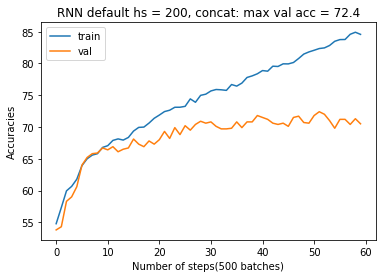

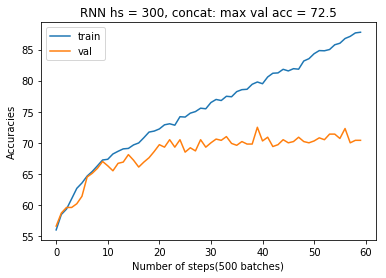

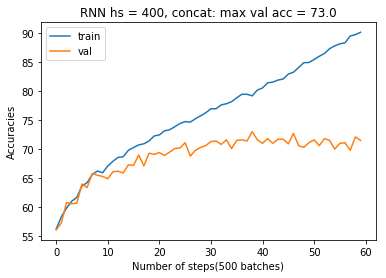

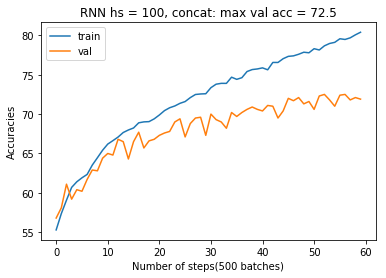

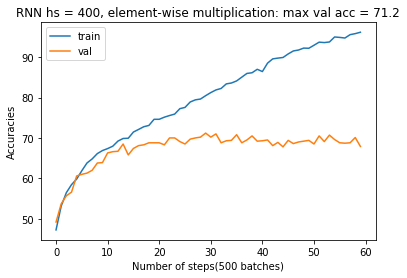

In [118]:
rnn_titles = ['default hs = 200, concat', 'hs = 300, concat',
          'hs = 400, concat', 'hs = 100, concat','hs = 400, element-wise multiplication'
          ]
plot_train_curves(rnn_train,rnn_val,rnn_titles,True)

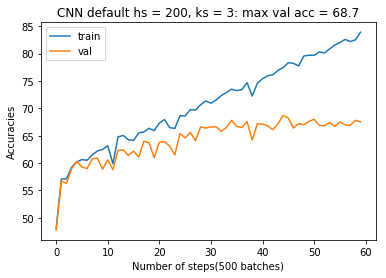

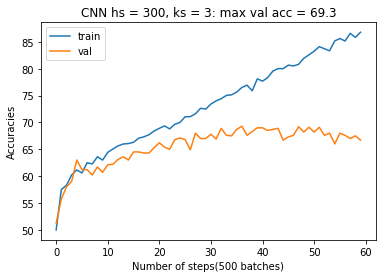

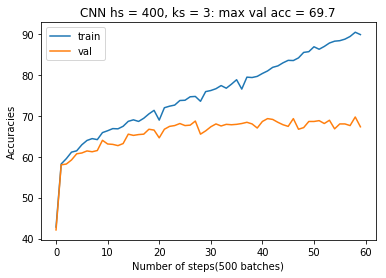

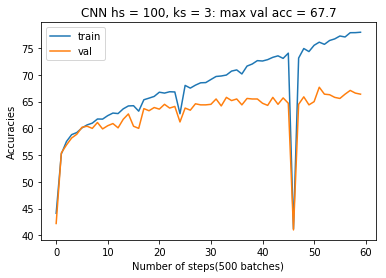

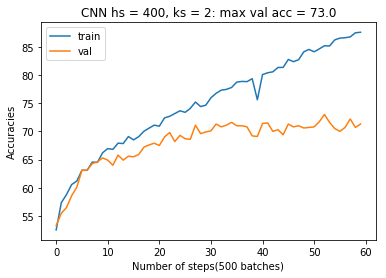

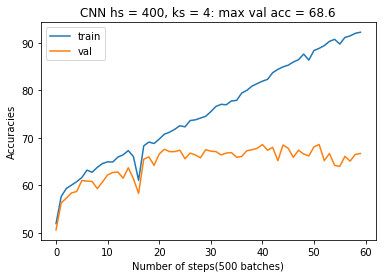

In [119]:
cnn_titles = ['default hs = 200, ks = 3', 'hs = 300, ks = 3',
          'hs = 400, ks = 3', 'hs = 100, ks = 3',
          'hs = 400, ks = 2', 'hs = 400, ks = 4'
          ]
plot_train_curves(cnn_train,cnn_val,cnn_titles,False)


### Best Models

In [73]:
model_rnn = RNN(weight = loaded_embeddings_ft,
                emb_size= 300, 
                hidden_size=400, 
                num_layers=1, 
                num_classes =3,
                element_mul = False).to(device)
model_rnn.load_state_dict(torch.load("rnn_hs_400.pth"))
model_rnn.eval()


RNN(
  (embedding): Embedding(50002, 300)
  (rnn): GRU(300, 400, batch_first=True, bidirectional=True)
  (fc): Sequential(
    (0): Linear(in_features=800, out_features=400, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=400, out_features=3, bias=True)
  )
  (fc1): Linear(in_features=800, out_features=400, bias=True)
  (relu): LeakyReLU(negative_slope=0.01, inplace)
  (fc2): Linear(in_features=400, out_features=3, bias=True)
)

In [103]:
model_cnn = CNN(weight = loaded_embeddings_ft,
                emb_size= 300, 
                hidden_size=400, 
                kernel_size=2, 
                num_classes =3
                ).to(device)
model_cnn.load_state_dict(torch.load("cnn_hs_400_ks_2.pth.pth",map_location = "cpu"))
model_cnn.eval()

CNN(
  (embedding): Embedding(50002, 300)
  (conv1): Conv1d(300, 400, kernel_size=(2,), stride=(1,), padding=(1,))
  (conv2): Conv1d(400, 400, kernel_size=(2,), stride=(1,), padding=(1,))
  (fc): Sequential(
    (0): Linear(in_features=800, out_features=400, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=400, out_features=3, bias=True)
  )
)

#### Load test data

In [80]:
def load_mnli(filename):
    train_s1 = []
    train_s2 = []
    train_genre = []
    train_label = []
    with open(filename) as tsvfile:
      reader = csv.reader(tsvfile, delimiter='\t')
      for row in reader:
            
        train_s1.append(row[0].split())
        
        train_s2.append(row[1].split())
        
        if row[2] == 'neutral': 
            train_label.append(1)
        elif row[2] == 'entailment':
            train_label.append(2)
        else:
            train_label.append(0)
        
        train_genre.append(row[3])
        
    train_s1 = train_s1[1:]
    train_s2 = train_s2[1:]
    
    
    train_label = train_label[1:]
    train_genre = train_genre[1:]
    
    return train_s1,train_s2, train_label, train_genre

In [81]:
test_s1,test_s2,test_label,test_genre = load_mnli('mnli_val.tsv')

In [82]:
genre_list = list(pd.Series(test_genre).unique())
genre_list

['fiction', 'telephone', 'slate', 'government', 'travel']

In [83]:
def load_mnli_by_genre(filename,genre):
    
    s1 = []
    s2 = []
    label = []
    with open(filename) as tsvfile:
      reader = csv.reader(tsvfile, delimiter='\t')
      for row in reader:
        
        if row[3] == genre:
            if len(row[0].split())<1000 and len(row[1].split())<1000:
                s1.append(row[0].split())
                s2.append(row[1].split())

                if row[2] == 'neutral': 
                    label.append(1)
                elif row[2] == 'entailment':
                    label.append(2)
                else:
                    label.append(0)

    return s1,s2,label
        
    

In [104]:
device = torch.device("cpu")
RNN_acc = []
CNN_acc = []
for genre in genre_list:
    test_s1,test_s2,test_label = load_mnli_by_genre('mnli_val.tsv',genre)
    test_s1_indices = token2index_dataset(test_s1)
    test_s2_indices = token2index_dataset(test_s2)
    test_dataset = load_dataset(test_s1_indices,test_s2_indices, test_label)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                               batch_size=32,
                                               collate_fn=collate_func,
                                               shuffle=True)  

    model_rnn = RNN(weight = loaded_embeddings_ft,
                    emb_size= 300, 
                    hidden_size=400, 
                    num_layers=1, 
                    num_classes =3,
                    element_mul = False).to(device)
    model_rnn.load_state_dict(torch.load("rnn_hs_400.pth",map_location = "cpu"))
    model_rnn.eval()

    model_cnn = CNN(weight = loaded_embeddings_ft,
                    emb_size= 300, 
                    hidden_size=400, 
                    kernel_size=2, 
                    num_classes =3
                    ).to(device)
    model_cnn.load_state_dict(torch.load("cnn_hs_400_ks_2.pth.pth", map_location = "cpu"))
    model_cnn.eval()
    
    rnn_test = test_model(test_loader, model_rnn)
    cnn_test = test_model(test_loader, model_cnn)
    RNN_acc.append(rnn_test)
    CNN_acc.append(cnn_test)
    print('RNN on',genre,': ',rnn_test)
    print('CNN on',genre,': ',cnn_test)



RNN on fiction :  50.55387713997986
CNN on fiction :  46.72708962739174
RNN on telephone :  49.15422885572139
CNN on telephone :  48.45771144278607
RNN on slate :  46.20758483033932
CNN on slate :  43.812375249500995
RNN on government :  48.326771653543304
CNN on government :  49.50787401574803
RNN on travel :  48.16700610997963
CNN on travel :  45.824847250509166


### Find 3 correct and 3 incorrect predictions

#### Best model:

In [122]:
device = torch.device("cpu")
best_model = RNN(weight = loaded_embeddings_ft,
                    emb_size= 300, 
                    hidden_size=400, 
                    num_layers=1, 
                    num_classes =3,
                    element_mul = False
                    ).to(device)

In [123]:
best_model.load_state_dict(torch.load("rnn_hs_400.pth",map_location = "cpu"))
best_model.eval()

RNN(
  (embedding): Embedding(50002, 300)
  (rnn): GRU(300, 400, batch_first=True, bidirectional=True)
  (fc): Sequential(
    (0): Linear(in_features=800, out_features=400, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=400, out_features=3, bias=True)
  )
  (fc1): Linear(in_features=800, out_features=400, bias=True)
  (relu): LeakyReLU(negative_slope=0.01, inplace)
  (fc2): Linear(in_features=400, out_features=3, bias=True)
)

In [124]:
correct_list = []
wrong_list = []

labels_correct = []
labels_wrong = []


cap = 100

for data_1,data_2, lengths_1,lengths_2, labels in val_loader:
    data_batch1,data_batch2, length_batch1,length_batch2, label_batch = data_1.to(device),data_2.to(device), lengths_1.to(device),lengths_2.to(device), labels.to(device)
    outputs = F.softmax(best_model(data_batch1,data_batch2, length_batch1,length_batch2), dim=1)
    predicted = outputs.max(1, keepdim=True)[1]

    for i in range(len(predicted)):
        if len(correct_list) < cap and len(wrong_list) < cap:
            if predicted[i]==label_batch[i]:
                
                correct_list.append((data_batch1[i],data_batch2[i]))
                labels_correct.append((predicted[i],label_batch[i]))
                
            else:
                wrong_list.append((data_batch1[i],data_batch2[i]))
                labels_wrong.append((predicted[i],label_batch[i]))
        else:
            break





In [125]:
def print_sent(sent_list, labels_list, ordered_words_ft):
    w=0
    for sent in sent_list:

        pred, actual = labels_list[w]

        if pred == torch.Tensor([0]).long():
            pred = 'Contradiction'
        elif pred == torch.Tensor([1]).long():
            pred = 'Neutral'
        else:
            pred = 'Entailment'

        if actual == torch.Tensor([0]).long():
            actual = 'Contradiction'
        elif actual == torch.Tensor([1]).long():
            actual = 'Neutral'
        else:
            actual = 'Entailment'

        print('S1: ',(" ").join([ordered_words_ft[i] for i in np.array(sent[0]) if i !=0]))
        print('S2: ',(" ").join([ordered_words_ft[i] for i in np.array(sent[1]) if i !=0]))

        print ('Predicted label: ',pred)
        print ('Actual label: ', actual)
        print ('\n')

        w += 1
        if w>6:
            break

In [126]:
print_sent(correct_list, labels_correct, ordered_words_ft)

S1:  A young girl with blue and pink ribbons in her <unk> , without a top and a woman with a white t-shirt and a zebra skirt wading in a public water fountain .
S2:  A young girl <unk> a sweater
Predicted label:  Contradiction
Actual label:  Contradiction


S1:  A shirtless man wearing a black hat and a scarf works on an <unk> .
S2:  A man works with an <unk> .
Predicted label:  Entailment
Actual label:  Entailment


S1:  Two brown and white dogs , one jumping over a log while the one behind runs through the grass .
S2:  The dogs are laying on a blanket .
Predicted label:  Contradiction
Actual label:  Contradiction


S1:  A group of people walk down a pedestrian only street in Asia near large green trees and older brown buildings .
S2:  The group of people is sitting under the trees .
Predicted label:  Contradiction
Actual label:  Contradiction


S1:  A young girl sits on a blue bench drinking out of a straw .
S2:  A girl is drinking through a straw on a humid day .
Predicted label:  N

In [127]:
print_sent(wrong_list, labels_wrong, ordered_words_ft)

S1:  A man <unk> in a kitchen while wearing gloves and a hat .
S2:  The man is baking a cake .
Predicted label:  Contradiction
Actual label:  Neutral


S1:  A person in orange climbs a sheer cliff face covered in snow and ice .
S2:  He is climbing the cliff
Predicted label:  Neutral
Actual label:  Entailment


S1:  A woman in a blue shirt and black workout pants practicing martial arts in front of a house .
S2:  A woman has a white shirt .
Predicted label:  Entailment
Actual label:  Contradiction


S1:  A child in shorts throws a snowball at a mountain .
S2:  A boy is playing in the snow without gloves
Predicted label:  Entailment
Actual label:  Neutral


S1:  A town worker working on electrical equipment .
S2:  The worker is off work for the day .
Predicted label:  Neutral
Actual label:  Contradiction


S1:  a surfer is riding the waves whilst another surfer sits on his board waiting .
S2:  A surfer watches as his friend is eaten by a large shark .
Predicted label:  Neutral
Actual lab